#**FACE MASK DETECTION USING DEEP-NETWORKS**

# **Libraries Used**

In [1]:
#Libraries Imported
from pathlib import Path
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from tqdm import tqdm
import shutil
from PIL import Image
import numpy as np
from torch import long
from torch import tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import functional
from torch.nn import AdaptiveAvgPool2d
from torch.nn import Dropout
from torchsummary import summary
from typing import Dict
from typing import List
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from numpy import vstack
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import random
import time
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#Downloading and unziooing the dataset
dirpath = Path('data/dataset')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
os.makedirs('data/dataset')
datasetPath = Path('data/dataset/dataset.zip')
gdd.download_file_from_google_drive(file_id='1tu9PmDx5mPCw1O-RTHLAzd25BGknsADQ',dest_path=str(datasetPath), unzip=True)
# delete zip file
datasetPath.unlink()

Unzipping...Done.


# **Prepare the pickle**

In [3]:
#Pickle assumption and loading the data
datasetPath = Path('data/dataset')
nonMaskPath = datasetPath/'without_mask'
maskPath = datasetPath/'with_mask'
randomPath = datasetPath/'random'
maskDF = pd.DataFrame()
for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='Wearing Mask'):
    maskDF = maskDF.append({'image': str(imgPath),'mask': 0}, ignore_index=True)
for imgPath in tqdm(list(maskPath.iterdir()), desc='Not Wearing Mask'):
    maskDF = maskDF.append({'image': str(imgPath),'mask': 1}, ignore_index=True)
for imgPath in tqdm(list(randomPath.iterdir()), desc='Not a Human'):
    maskDF = maskDF.append({'image': str(imgPath),'mask': 2}, ignore_index=True)
print()
dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Not a Human: 100%|██████████| 3710/3710 [00:09<00:00, 386.06it/s]


Saving Dataframe to: data/dataset/dataset.pickle


# **The Dataset class - Normalization**

In [4]:
#Class assumption of the dataset
class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([Resize((32, 32)),ToTensor(), Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))])
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {'image': self.transformations(image),'mask': tensor([row['mask']], dtype=long),'path': row['image']}
    def __len__(self):
        return len(self.dataFrame.index)

#**MODELS**

# **VGG model for face mask detection**

In [5]:
'''#VGG Architecture
class FaceMaskDetectorCNN(torch.nn.Module) :
    def __init__(self) :
        super(FaceMaskDetectorCNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_layer3 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.Conv2d(256, 256, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.MaxPool2d(kernel_size=2, stride=2)           )
        self.conv_layer4 = torch.nn.Sequential(torch.nn.Conv2d(256, 512, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.ReLU(), 
                                               torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc_layer1 = torch.nn.Sequential(torch.nn.Dropout(0.2), torch.nn.Linear(1024*2, 4096), torch.nn.ReLU())
        self.fc_layer2 = torch.nn.Sequential(torch.nn.Dropout(0.2), torch.nn.Linear(4096, 4096), torch.nn.ReLU())
        self.fc_layer3 = torch.nn.Sequential(torch.nn.Linear(4096, 10))
        
    def forward(self, out) :
        final_out = self.conv_layer1(out)
        final_out = self.conv_layer2(final_out)
        final_out = self.conv_layer3(final_out)
        final_out = self.conv_layer4(final_out)
        final_out = final_out.view(-1, 1024*2)
        final_out = self.fc_layer1(final_out)
        final_out = self.fc_layer2(final_out)
        final_out = self.fc_layer3(final_out)
        return final_out

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))'''

'#VGG Architecture\nclass FaceMaskDetectorCNN(torch.nn.Module) :\n    def __init__(self) :\n        super(FaceMaskDetectorCNN, self).__init__()\n        self.conv_layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, padding=1), torch.nn.ReLU(), \n                                               torch.nn.MaxPool2d(kernel_size=2, stride=2))\n        self.conv_layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, padding=1), torch.nn.ReLU(), \n                                               torch.nn.MaxPool2d(kernel_size=2, stride=2))\n        self.conv_layer3 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=3, padding=1), torch.nn.ReLU(), \n                                               torch.nn.Conv2d(256, 256, kernel_size=3, padding=1), torch.nn.ReLU(), \n                                               torch.nn.MaxPool2d(kernel_size=2, stride=2)           )\n        self.conv_layer4 = torch.nn.Sequential(torch.nn.Conv2d(256, 512, kernel_size=3, paddi

#**ResNet model for face mask detection**

In [6]:
'''#ResNet Architecture
class bottleneck_resnet(torch.nn.Module):
    Extension_Net = 1
    def __init__(self, Channel_In, filter_channel, stride=1):
        super(bottleneck_resnet, self).__init__()
        self.convolutional_layer1 = torch.nn.Conv2d(Channel_In, filter_channel, kernel_size=3, stride=stride, padding=1, bias=True)
        self.normalization_layer1 = torch.nn.BatchNorm2d(filter_channel)
        self.convolutional_layer2 = torch.nn.Conv2d(filter_channel, filter_channel, kernel_size=3, stride=1, padding=1, bias=True)
        self.normalization_layer2 = torch.nn.BatchNorm2d(filter_channel)
        self.Pass_route = torch.nn.Sequential()
        if stride != 1 or Channel_In != self.Extension_Net * filter_channel:
            self.Pass_route = torch.nn.Sequential(torch.nn.Conv2d(Channel_In, self.Extension_Net * filter_channel, kernel_size=1, stride=stride, bias=True),
                                                  torch.nn.BatchNorm2d(self.Extension_Net * filter_channel))

    def forward(self, out):
        final_out = torch.nn.functional.relu(self.normalization_layer1(self.convolutional_layer1(out)))
        final_out = self.normalization_layer2(self.convolutional_layer2(final_out))
        final_out += self.Pass_route(out)
        final_out = torch.nn.functional.relu(final_out)
        return final_out

#creating the architecture of the RESNET 
class ResNet(torch.nn.Module):
    #initialise the convolutional layer to append the hyperparameters 
    def ResNet_conv_layer(self, conv_net, filter_channel, conv_net_int, stride):
        ST = [stride] + [1]*(conv_net_int-1)
        net_layer = []
        for stride in ST :
            net_layer.append(conv_net(self.Channel_In, filter_channel, stride))
            self.Channel_In = filter_channel * conv_net.Extension_Net
        return torch.nn.Sequential(*net_layer)

    def __init__(self, conv_net, conv_net_int, num_classes=10):
        super(ResNet, self).__init__()
        self.Channel_In = 64
        self.Conv_layer1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.batchnorm_layer1 = torch.nn.BatchNorm2d(64)
        self.Resnet_defined_layer1 = self.ResNet_conv_layer(conv_net, 64, conv_net_int[0], stride=1)
        self.Resnet_defined_layer2 = self.ResNet_conv_layer(conv_net, 128, conv_net_int[1], stride=2)
        self.Resnet_defined_layer3 = self.ResNet_conv_layer(conv_net, 256, conv_net_int[2], stride=2)
        self.Resnet_defined_layer4 = self.ResNet_conv_layer(conv_net, 512, conv_net_int[3], stride=2)
        self.final_layer = torch.nn.Linear(512 * conv_net.Extension_Net, num_classes)

    def forward(self, out):
        final_out = torch.nn.functional.relu(self.batchnorm_layer1(self.Conv_layer1(out)))
        final_out = self.Resnet_defined_layer1(final_out)
        final_out = self.Resnet_defined_layer2(final_out)
        final_out = self.Resnet_defined_layer3(final_out)
        final_out = self.Resnet_defined_layer4(final_out)
        final_out = torch.nn.functional.avg_pool2d(final_out, 4)
        final_out = final_out.view(out.size(0), -1)
        final_out = self.final_layer(final_out)
        return final_out

#defining the resnet Network type
def FaceMaskDetectorCNN():
    return ResNet(bottleneck_resnet, [3, 4, 6, 3])

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))'''

'#ResNet Architecture\nclass bottleneck_resnet(torch.nn.Module):\n    Extension_Net = 1\n    def __init__(self, Channel_In, filter_channel, stride=1):\n        super(bottleneck_resnet, self).__init__()\n        self.convolutional_layer1 = torch.nn.Conv2d(Channel_In, filter_channel, kernel_size=3, stride=stride, padding=1, bias=True)\n        self.normalization_layer1 = torch.nn.BatchNorm2d(filter_channel)\n        self.convolutional_layer2 = torch.nn.Conv2d(filter_channel, filter_channel, kernel_size=3, stride=1, padding=1, bias=True)\n        self.normalization_layer2 = torch.nn.BatchNorm2d(filter_channel)\n        self.Pass_route = torch.nn.Sequential()\n        if stride != 1 or Channel_In != self.Extension_Net * filter_channel:\n            self.Pass_route = torch.nn.Sequential(torch.nn.Conv2d(Channel_In, self.Extension_Net * filter_channel, kernel_size=1, stride=stride, bias=True),\n                                                  torch.nn.BatchNorm2d(self.Extension_Net * filter_

# **GoogleNet model for face mask detection**

In [7]:
'''#GoogleNet Architecture
class Convolutional_2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Convolutional_2d, self).__init__()
        self.convlayer = nn.Sequential(nn.Conv2d(in_channels, out_channels, **kwargs), nn.ReLU())
    def forward(self, out):
        return self.convlayer(out)

class Inception(torch.nn.Module):
    def __init__(self, Channel_In, channel1, channel2, channel3, channel4, channel5, incep_pooling):
        super(Inception, self).__init__()
        #Inception layer1 has the single 1x1 kernel size convolutional layer
        self.inception1 = Convolutional_2d(Channel_In, channel1, kernel_size=1)
        #Inception layer2 has the 1x1 kernel size convolutional layer and a 3x3 convolutional layer
        self.inception2 = torch.nn.Sequential(Convolutional_2d(Channel_In, channel2, kernel_size=1), Convolutional_2d(channel2, channel3, kernel_size=3, padding=1))
        #Inception layer3 has the 1x1 kernel size convolutional layer and a 5x5 convolutional layer
        self.inception3 = torch.nn.Sequential(Convolutional_2d(Channel_In, channel4, kernel_size=1), Convolutional_2d(channel4, channel5, kernel_size=5, padding=2))
        #Inception layer4 has the 3x3 maximum pooling layer and a 1x1 convolutional layer
        self.inception4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1), Convolutional_2d(Channel_In, incep_pooling, kernel_size=1))

    def forward(self, out):
        inception1 = self.inception1(out)
        inception2 = self.inception2(out)
        inception3 = self.inception3(out)
        inception4 = self.inception4(out)
        return torch.cat([inception1, inception2, inception3, inception4], 1)

#GOOGLENET NETWORK
#creating the googlenet convolutional layers with inception
class FaceMaskDetectorCNN(torch.nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__() 
        self.Gnet_convlayer1 = Convolutional_2d(3, 64, kernel_size=7, padding=3)
        self.Gnet_convlayer2 = Convolutional_2d(64, 64, kernel_size=1)
        self.Gnet_convlayer3 = Convolutional_2d(64, 192, kernel_size=5)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32) 
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pooling_3 = torch.nn.MaxPool2d(3, stride=2)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pooling_4 = torch.nn.MaxPool2d(2, stride=2)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(1024, 10)
      
    def forward(self, final_out):
        final_out = self.Gnet_convlayer1(final_out)
        final_out = self.Gnet_convlayer2(final_out)
        final_out = self.Gnet_convlayer3(final_out)
        final_out = self.inception_3a(final_out)
        final_out = self.inception_3b(final_out)
        final_out = self.pooling_3(final_out)
        final_out = self.inception_4a(final_out)
        final_out = self.inception_4b(final_out)
        final_out = self.inception_4c(final_out)
        final_out = self.inception_4d(final_out)
        final_out = self.inception_4e(final_out)
        final_out = self.pooling_4(final_out)
        final_out = self.inception_5a(final_out)
        final_out = self.inception_5b(final_out)
        final_out = self.avgpooling(final_out)
        final_out = torch.flatten(final_out, 1)
        final_out = self.dropout(final_out)
        final_out = self.out(final_out)
        return final_out

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))'''

'#GoogleNet Architecture\nclass Convolutional_2d(nn.Module):\n    def __init__(self, in_channels, out_channels, **kwargs):\n        super(Convolutional_2d, self).__init__()\n        self.convlayer = nn.Sequential(nn.Conv2d(in_channels, out_channels, **kwargs), nn.ReLU())\n    def forward(self, out):\n        return self.convlayer(out)\n\nclass Inception(torch.nn.Module):\n    def __init__(self, Channel_In, channel1, channel2, channel3, channel4, channel5, incep_pooling):\n        super(Inception, self).__init__()\n        #Inception layer1 has the single 1x1 kernel size convolutional layer\n        self.inception1 = Convolutional_2d(Channel_In, channel1, kernel_size=1)\n        #Inception layer2 has the 1x1 kernel size convolutional layer and a 3x3 convolutional layer\n        self.inception2 = torch.nn.Sequential(Convolutional_2d(Channel_In, channel2, kernel_size=1), Convolutional_2d(channel2, channel3, kernel_size=3, padding=1))\n        #Inception layer3 has the 1x1 kernel size conv

# **CNN model for face mask detection**

In [8]:
class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 3)
    
    def forward(self, x: Tensor):
        out = functional.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = functional.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()
print(summary(face_mask_detector_cnn,input_size=(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2            [-1, 8, 16, 16]           1,160
            Linear-3                   [-1, 32]          16,416
            Linear-4                    [-1, 3]              99
Total params: 18,123
Trainable params: 18,123
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
----------------------------------------------------------------
None


# **Split test and validation data**

In [9]:
#Confusion Matrix
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("---------------------------------------")
        print("Normalized confusion matrix")
        print("---------------------------------------")
    else:
        print("---------------------------------------")
        print('Confusion matrix, without normalization')
        print("---------------------------------------")
    print("----------------------------------")
    print(cm)
    print("----------------------------------")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        validate_folds = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(MaskDetectionDataset(mask_df.iloc[train_index]))
            validate_folds.append(MaskDetectionDataset(mask_df.iloc[validate_index]))
        return [train_folds, validate_folds, CrossEntropyLoss()]
def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)
def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   
train_dfs, validate_dfs, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

0.0    3828
1.0    3725
2.0    3710
Name: mask, dtype: int64


# **Training the model**

In [10]:
#@title Hyperparameters
epochs = 10 #@param {type:"slider", min:10, max:100, step:1}
learning_rate = 0.001 #@param {type:"number"}

In [11]:
#Training the model
retrain = False
def train_model(train_fold):
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        face_mask_detector_cnn.train()
        cv = 0
        ep_start = time.time()
        Sum_training_Loss = torch.tensor([0.0])
        Sum_training_Accuracy = torch.tensor([0.0])
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                labels = labels.long()
                Sum_training_Loss += loss.float()
                Sum_training_Accuracy += (torch.sum((torch.argmax(outputs, dim=1) == labels))).float()
                cv += labels.shape[0]
                final_loss = Sum_training_Loss/cv
                final_train_accuracy = Sum_training_Accuracy/cv
        print("----------------------------------------------------------------------------------------------------")
        print('Epoch--> %d\t Train_Loss: %.4f\t Train_Accuracy: %.2f\t Time_Duration: %.1f sec\t' % (epoch + 1, Sum_training_Loss, Sum_training_Accuracy, time.time() - ep_start))
        print("----------------------------------------------------------------------------------------------------")


# **Evaluate the model** 

In [12]:
#Evaluate the model
def evaluate_model(validate_fold):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_fold)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)
    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

# **Run the k-fold training and evaluation**

In [13]:
#Run k-fold training and the validation
fold_results = []
fold_confusion_matrix = np.zeros((3,3))
classes = ['Not Wearing Mask', 'Wearing Mask', 'Not a Human']
for fold_index in range(len(train_dfs)):
    print("-----------------")
    print("K-fold -->", fold_index+1)
    print("-----------------")
    train_model(train_dfs[fold_index])
    fold_result = evaluate_model(validate_dfs[fold_index])
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if fold_index != len(train_dfs)-1:
        face_mask_detector_cnn = FaceMaskDetectorCNN()  

-----------------
K-fold --> 1
-----------------
----------------------------------------------------------------------------------------------------
Epoch--> 1	 Train_Loss: 188.6096	 Train_Accuracy: 7792.00	 Time_Duration: 39.1 sec	
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch--> 2	 Train_Loss: 137.8471	 Train_Accuracy: 8439.00	 Time_Duration: 39.1 sec	
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch--> 3	 Train_Loss: 114.9752	 Train_Accuracy: 8713.00	 Time_Duration: 36.8 sec	
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------

In [31]:
metrics_df = pd.DataFrame(fold_results, columns=['accuracy   -->', 'precision  -->', 'recall     -->', 'f-score    -->'])
print("METRICS")
print("----------------------------")
print(metrics_df.mean())
print("----------------------------")

METRICS
----------------------------
accuracy   -->    0.903401
precision  -->    0.904173
recall     -->    0.903303
f-score    -->    0.903275
dtype: float64
----------------------------


Across 10-folds
---------------------------------------
Confusion matrix, without normalization
---------------------------------------
----------------------------------
[[3504.  185.  139.]
 [ 201. 3303.  221.]
 [ 167.  175. 3368.]]
----------------------------------


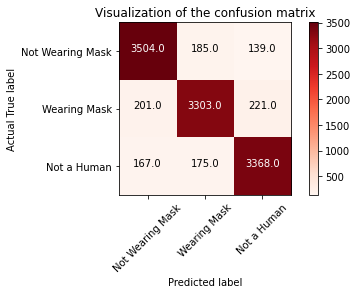

In [32]:
print("Across 10-folds")
plot_cm(fold_confusion_matrix, classes)

# **Predict the category of an image taken from a test dataset**

In [33]:
#Prediction
class_mapping = {0: "Not Wearing Mask",1: "Wearing Mask",2: "Not a Human"}
def prepare_predict_df():
    testDatasetPath = Path('/content/data/dataset')
    testNonMaskPath = testDatasetPath/'without_mask'
    testMaskPath = testDatasetPath/'with_mask'
    testRandomPath = testDatasetPath/'random'
    testDF = pd.DataFrame()
    for imgPath in tqdm(list(testMaskPath.iterdir()), desc='Wearing Mask'):
        testDF = testDF.append({'image': str(imgPath),'mask': 1}, ignore_index=True)
    for imgPath in tqdm(list(testNonMaskPath.iterdir()), desc='Not Wearing Mask'):
        testDF = testDF.append({'image': str(imgPath),'mask': 0}, ignore_index=True)
    for imgPath in tqdm(list(testRandomPath.iterdir()), desc='Not a Human'):
        testDF = testDF.append({'image': str(imgPath),'mask': 2}, ignore_index=True)
    return MaskDetectionDataset(testDF)

Not a Human: 100%|██████████| 3710/3710 [00:10<00:00, 364.68it/s]


------------------------------
Actual: Wearing Mask
------------------------------
Predicted: Wearing Mask
------------------------------


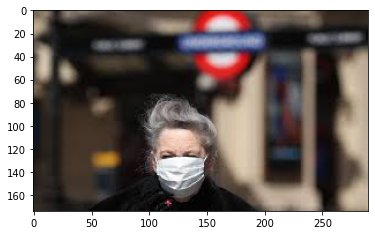

In [45]:
def predict():
  test_df = prepare_predict_df()
  rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
  data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("------------------------------")
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("------------------------------")
  print("Predicted:",class_mapping[output[rand_ind].tolist()])
  print("------------------------------")
predict()

Not a Human: 100%|██████████| 3710/3710 [00:09<00:00, 376.77it/s]


------------------------------
Actual: Not Wearing Mask
------------------------------
Predicted: Not Wearing Mask
------------------------------


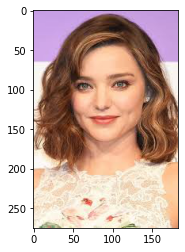

In [42]:
def predict():
  test_df = prepare_predict_df()
  rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
  data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("------------------------------")
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("------------------------------")
  print("Predicted:",class_mapping[output[rand_ind].tolist()])
  print("------------------------------") 
predict()

Not a Human: 100%|██████████| 3710/3710 [00:09<00:00, 376.65it/s]


------------------------------
Actual: Not a Human
------------------------------
Predicted: Not a Human
------------------------------


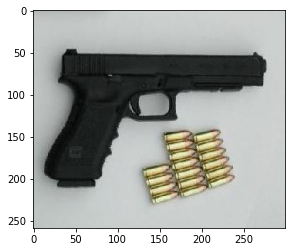

In [43]:
def predict():
  test_df = prepare_predict_df()
  rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
  data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("------------------------------")
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("------------------------------")
  print("Predicted:",class_mapping[output[rand_ind].tolist()])
  print("------------------------------")
predict()

Not a Human: 100%|██████████| 3710/3710 [00:09<00:00, 381.54it/s]


------------------------------
Actual: Wearing Mask
------------------------------
Predicted: Wearing Mask
------------------------------


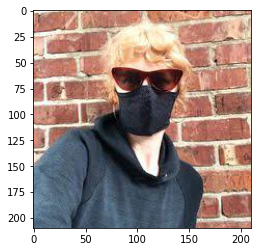

In [44]:
def predict():
  test_df = prepare_predict_df()
  rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
  data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("------------------------------")
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("------------------------------")
  print("Predicted:",class_mapping[output[rand_ind].tolist()])
  print("------------------------------")
predict()